<a href="https://colab.research.google.com/github/YinGuoX/Deep_Learning_Keras_WithDeeplizard/blob/master/14_Build_A_Fine_Tuned_Neural_Network_With_TensorFlow's_Keras_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build A Fine-Tuned Neural Network With TensorFlow's Keras API
在本集中，我们将演示如何微调经过预先训练的模型，以将图像分类为猫和狗。

## 1.VGG16和ImageNet
我们将用来对猫和狗的图像进行分类的预训练模型称为VGG16，它是赢得2014年[ImageNet](http://www.image-net.org/)竞赛的模型。

在ImageNet竞赛中，多个团队竞争以建立一个模型，该模型对ImageNet库中的图像进行最佳分类。 ImageNet库中包含成千上万个属于1000个不同类别的图像。

我们将导入此VGG16模型，然后使用Keras对其进行微调。 经过微调的模型不会将图像分类为对其进行训练的1000个类别之一，而是只能将图像分类为猫或狗。

注意，狗和猫都包含在最初训练VGG16的ImageNet库中。因此，该模型已经学习了猫和狗的特征。鉴于此，我们将对该模型进行的微调将非常少。在后面的章节中，我们将进行更多的微调，并利用迁移学习来分类全新的数据，而不是包含在训练集中的数据。

## 2.VGG16预处理
让我们首先使用前面引入的绘图函数检查一批训练数据。

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%tensorflow_version 2.x
print(tf.__version__)

2.4.0


In [ ]:
# 在colab上使用的云端数据
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = "/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data/dogs-vs-cats"

# 更改当前系统的路径
os.chdir(path)
# 显示当前路径的文件夹名字
print(os.listdir())

# 获得当前路径
os.getcwd()

['train', 'valid', 'test', 'Dog', 'Cat']


'/content/drive/My Drive/DeepLearning_AI_Course/Deeplizard/Keras - Python Deep Learning Neural Network API/Data/dogs-vs-cats'

In [ ]:
os.chdir('..')
print(os.listdir())
train_path = './dogs-vs-cats/train'
valid_path = './dogs-vs-cats/valid'
test_path = './dogs-vs-cats/test'
num_steps = 100
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

['dogs-vs-cats']
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

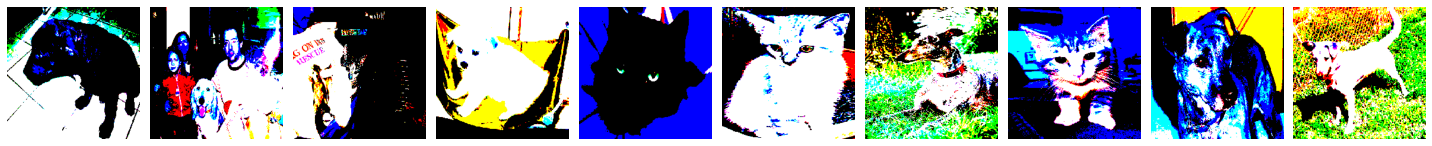

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

当我们之前检查这些图像时，我们简要地讨论了颜色数据由于使用tf.keras.applications.vgg16对图像进行预处理而产生的偏移。

为了理解为什么需要将图像传递给VGG16模型进行预处理，我们可以看看[VGG16](https://arxiv.org/pdf/1409.1556.pdf)的论文。

在2.1架构部分，我们可以看到作者声明，“我们做的唯一预处理是从每个像素减去在训练集上计算的平均RGB值。”

这是对原始训练数据使用的预处理，因此，这是我们在将图像传递给VGG16或经过微调的VGG16模型之前需要处理图像的方式。这种处理方式导致底层的颜色数据看起来失真。



## 2.构建一个经过微调的模型

我们将从Keras导入VGG16模型。注意，下载这个模型需要一个联网。

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


原始的训练过的VGG16模型，以及它保存的权重和其他参数，现在已经下载到我们的机器上。我们可以查看模型的摘要，看看体系结构是什么样的。

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

相比之下，回想一下我们在上一集节目中看到的CNN是多么的简单。VGG16比我们之前的模型更加复杂和复杂，并且有更多的层。

**注意**VGG16的最后一个密集层有1000个输出。这些输出对应于ImageNet库中的1000个类别。

因为我们将只对猫和狗这两个类别进行分类，所以我们需要修改这个模型，以便它做我们希望它做的事情，也就是只对猫和狗进行分类。

在此之前，请注意，到目前为止，我们在本系列中使用的Keras模型类型都是Sequential类型。

如果我们检查模型vgg16_model的类型，我们会发现它属于model类型，因为它来自Keras的函数API。

In [ ]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

我们还没有使用更复杂的函数API，尽管我们将在后面的章节中使用MobileNet模型来使用它。

我们首先创建一个类型为Sequential的新模型。然后迭代vgg16_model中的每一层(最后一层除外)，并将每一层添加到新的顺序模型中。

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

现在，我们已经将整个vgg16模型(不包括输出层)复制到一个新的顺序模型，我们刚刚将其命名为model。

接下来，我们将迭代我们新的顺序模型中的每个层，并将它们设置为不可训练的。这将在每一层冻结权重和其他可训练参数，这样当我们稍后传入猫和狗的图像时，它们就不会被训练或更新。

In [ ]:
for layer in model.layers:
  layer.trainable=False

我们不想重新训练这些层的原因是，如前所述，猫和狗已经包含在原始的ImageNet库中了。所以，VGG16在分类这些类别方面已经做得很好了。我们只想修改模型，使输出层只知道如何对猫和狗进行分类，其他的什么都不知道。因此，我们不希望在前面的层上进行任何再培训。

接下来，我们添加新的输出层，只包含对应于cat和dog的两个节点。这个输出层将是模型中唯一可训练的层。

In [ ]:
model.add(Dense(units=2,activation = 'softmax'))

现在我们可以看看我们的模型的摘要,看看这一切是完全一样的原始vgg16模型,除了现在,输出层只有2个节点,而不是1000个,可训练的参数的数量已经大大减少了因为我们冻结了所有的参数在前面的层。

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

在下一集中，我们将看到如何在猫和狗的图像上训练这个修改过的模型。